In [1]:
from sklearn import preprocessing
from pysurvival.utils.display import correlation_matrix
import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def load_data(index=0, fp='.'):
    """ 0: C7
        1: C8
        2: C9
        3: C11
        4: C13
        5: C14
        6: C15
        7: C16

        Note that C7 and C13 included a short break
        (for about 100 timestamps long)
        between the two procedure.

    """
    if index == 0:
        df = pd.read_csv(fp + '/C7-1.csv.gz')
        df = pd.concat([df, pd.read_csv(fp + '/C7-2.csv.gz')])
        df = df.reset_index(drop=True)
        df.Timestamp = df.index.values
        return df
    elif index == 1:
        return pd.read_csv(fp + '/C8.csv.gz')
    elif index == 2:
        return pd.read_csv(fp + '/C9.csv.gz')
    elif index == 3:
        return pd.read_csv(fp + '/C11.csv.gz')
    elif index == 4:
        df = pd.read_csv(fp + '/C13-1.csv.gz')
        df = pd.concat([df, pd.read_csv(fp + '/C13-2.csv.gz')])
        df = df.reset_index(drop=True)
        df.Timestamp = df.index.values
        return df
    elif index == 5:
        return pd.read_csv(fp + '/C14.csv.gz')
    elif index == 6:
        return pd.read_csv(fp + '/C15.csv.gz')
    elif index == 7:
        return pd.read_csv(fp + '/C16.csv.gz')
    else:
        raise ValueError


In [3]:
def rename_components(df):
    """ current and speed
    """
    # Rename L
    L_curr = ['L_1', 'L_3', 'L_4', 'L_7', 'L_9']
    L_speed = ['L_2', 'L_6', 'L_5', 'L_8', 'L_10']
    df = df.rename(columns={k: f'c{i}_curr' for i, k in enumerate(L_curr)})
    df = df.rename(columns={k: f'c{i}_speed' for i, k in enumerate(L_speed)})

    # Rename A, B, and C
    df = df.rename(columns={f'A_{i}': f'c5_val{i}' for i in range(1, 6)})
    df = df.rename(columns={f'B_{i}': f'c6_val{i}' for i in range(1, 6)})
    df = df.rename(columns={f'C_{i}': f'c7_val{i}' for i in range(1, 6)})

    return df[df.columns.sort_values()]


In [4]:
def load_clean_data(index=0):
    return rename_components(load_data(index=i))


In [5]:
for i in range(8):
    df = rename_components(load_data(index=i))
    print(df.shape)

(51671, 26)
(15803, 26)
(34245, 26)
(18429, 26)
(23670, 26)
(32848, 26)
(30737, 26)
(21021, 26)


In [6]:
def set_broken_labels(df, size):
    labels = np.zeros(df.shape[0])
    labels[-size:] = 1
    df['broken'] = labels
    return df

In [7]:
def run_to_failure_aux(df, n_sample, desc=''):

    seq_len = df.shape[0]
    samples = []
    pbar = tqdm.tqdm(total=n_sample, desc=desc)

    while len(samples) < n_sample:
        # random censoring
        t = np.random.randint(seq_len)
        sample = {'lifetime': t, 'broken': df.loc[t, 'broken']}
        sample = pd.DataFrame(sample, index=[0])
        features = df.iloc[:t].mean(axis=0)[:-1]
        sample[features.keys()] = features.values
        samples.append(sample)
        # break
        pbar.update(1)

    return pd.concat(samples, axis=0).reset_index(drop=True)


In [9]:
def generate_run_to_failure(n_sample=1000, bronken_holdout_steps=2000):

    samples = []
    print('Generating run-to-failure data:')

    for index in range(8):
        raw_df = load_clean_data(index=index).set_index('Timestamp')
        raw_df = set_broken_labels(raw_df, size=bronken_holdout_steps)
        sample = run_to_failure_aux(raw_df, n_sample, desc=f'component {index+1}/8')
        sample['trial_id'] = index
        samples.append(sample)

    return pd.concat(samples, axis=0).reset_index(drop=True)

In [141]:
dataset = generate_run_to_failure()

Generating run-to-failure data:


8/8: 100%|██████████| 1000/1000 [00:05<00:00, 174.08it/s]


<AxesSubplot:>

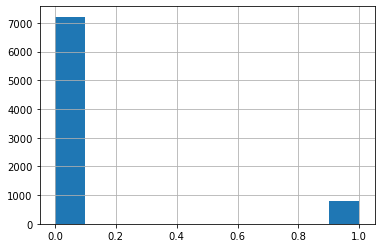

In [148]:
dataset.broken.hist()

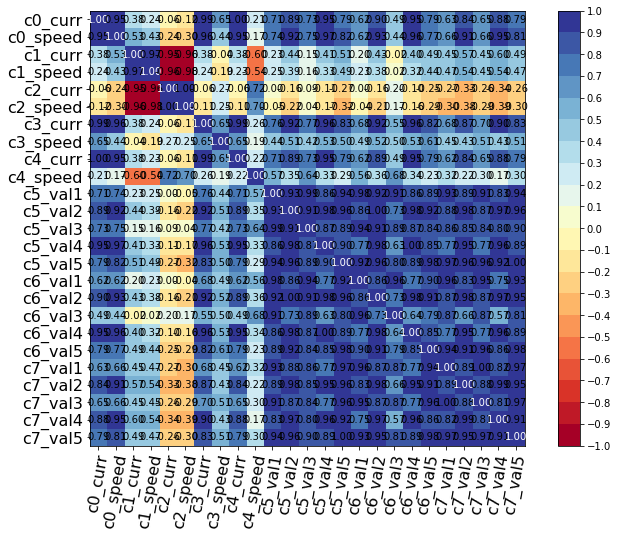

In [149]:
dataset.iloc[:, 2:-1] = preprocessing.scale(dataset.iloc[:, 2:-1])
correlation_matrix(dataset.iloc[:, 2:-1])


In [ ]:
def generate_validation_sets():
    return